<a href="https://colab.research.google.com/github/Adrita0808/pcos-detection-accurately/blob/main/pcos_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install and import necessary libraries, download datasets

!pip install opendatasets --quiet

import opendatasets as od

# Download datasets from Kaggle
od.download("https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images")
od.download("https://www.kaggle.com/datasets/emanali980/pcos-images")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adritaadnin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images


100%|██████████| 126M/126M [00:00<00:00, 905MB/s] 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adritaadnin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/emanali980/pcos-images


100%|██████████| 8.43M/8.43M [00:00<00:00, 1.22GB/s]

In [ ]:
# Cell 2: Importing core libraries

import numpy as np
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16, EfficientNetB7, ResNet50, DenseNet121, EfficientNetB0, InceptionV3, MobileNetV2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# Cell 3: Checking TensorFlow and Keras versions

import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.18.0
Keras Version: 3.8.0


In [ ]:
# Cell 4: Define local dataset paths after download

dataset_1 = "/content/pcos-detection-using-ultrasound-images/data/train"
dataset_2 = "/content/pcos-images/Dataset pcos"


In [ ]:
# Cell 5: Print images per class in both datasets

for class_name in os.listdir(dataset_1):
    print(f"{class_name}: {len(os.listdir(os.path.join(dataset_1, class_name)))} train images")

for class_name in os.listdir(dataset_2):
    print(f"{class_name}: {len(os.listdir(os.path.join(dataset_2, class_name)))} test images")


infected: 781 train images
notinfected: 1143 train images
PCOS: 100 test images
Normal: 100 test images


In [ ]:
# Cell 6: Prepare combined dataset directory and class mapping

combined_dir = "/content/combined_dataset"
new_train_dir = "/content/combined_train"
new_test_dir = "/content/combined_test"

os.makedirs(combined_dir, exist_ok=True)
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

class_mapping = {
    "notinfected": "Normal",
    "infected": "PCOS",
    "Normal": "Normal",
    "PCOS": "PCOS"
}


In [ ]:
# Cell 7: Merge both datasets under correct class names

for dataset_path in [dataset_1, dataset_2]:
    for class_name in os.listdir(dataset_path):
        original_class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(original_class_path):
            continue
        new_class_name = class_mapping.get(class_name, None)
        if new_class_name is None:
            print(f" Warning: Unknown class '{class_name}', skipping.")
            continue
        combined_class_path = os.path.join(combined_dir, new_class_name)
        os.makedirs(combined_class_path, exist_ok=True)
        for img in os.listdir(original_class_path):
            shutil.copy(os.path.join(original_class_path, img), os.path.join(combined_class_path, img))


In [ ]:
# Cell 8: Split combined dataset (90% train, 10% test)

for class_name in ["Normal", "PCOS"]:
    class_path = os.path.join(combined_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(new_test_dir, class_name), exist_ok=True)
    split_index = int(0.9 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_train_dir, class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_test_dir, class_name, img))


In [ ]:
# Cell 9: Print summary of train/test split

print(f"Train folder: {new_train_dir}")
print(f"Test folder: {new_test_dir}")

for class_name in os.listdir(new_train_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_train_dir, class_name)))} train images")
for class_name in os.listdir(new_test_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_test_dir, class_name)))} test images")


Train folder: /content/combined_train
Test folder: /content/combined_test
PCOS: 792 train images
Normal: 1118 train images
PCOS: 89 test images
Normal: 125 test images


In [ ]:
# Cell 10: Model parameters

batch_size = 128
img_height = img_width = 224


In [ ]:
# Cell 11: Data augmentation setup

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Cell 12: Prepare data generators for train and test

train_generator = train_datagen.flow_from_directory(
    new_train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="rgb",
    seed=12
)

test_generator_1 = test_datagen.flow_from_directory(
    new_test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    color_mode="rgb",
    shuffle=False
)


Found 1910 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [ ]:
# Cell 13: Get one batch and verify shape/color channels

sample_batch, sample_labels = next(train_generator)
print("Sample image shape:", sample_batch[0].shape)  # (224, 224, 3)
print("Are all RGB channels identical?", np.all(sample_batch[0][:, :, 0] == sample_batch[0][:, :, 1]) and np.all(sample_batch[0][:, :, 1] == sample_batch[0][:, :, 2]))


Sample image shape: (224, 224, 3)
Are all RGB channels identical? True


In [ ]:
# Cell 14: Build and train MobileNetV2 model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output_layer)
model_mobilenet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_mobile = model_mobilenet.fit(
    train_generator,
    epochs=5,
    verbose=1
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6588 - loss: 7.8209
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9724 - loss: 0.2962
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9910 - loss: 0.1025
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9960 - loss: 0.1279
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9978 - loss: 0.0185


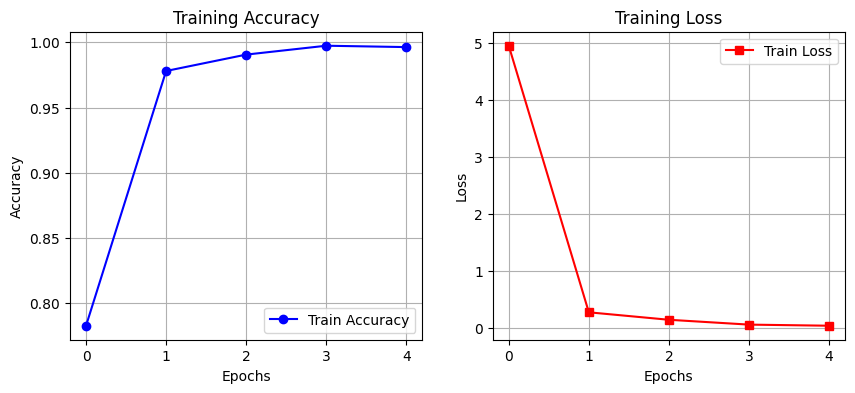

In [ ]:
# Cell 15: Plot training accuracy and loss

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mobile.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_mobile.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 1.0000 - loss: 1.5014e-15
Test Loss: 0.0000, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



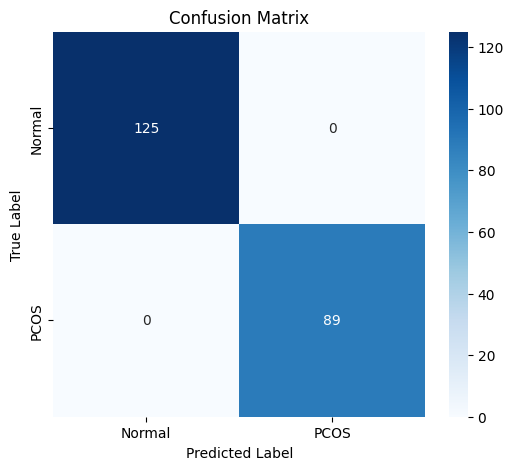

In [ ]:
# Cell 16: Evaluate model and show classification report and confusion matrix

test_loss, test_acc = model_mobilenet.evaluate(test_generator_1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_true = test_generator_1.classes
y_pred_probs = model_mobilenet.predict(test_generator_1)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install opencv-python --quiet


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_img_array(img_path, size):
    # Load image, resize, scale [0,1]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool gradients over each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv outputs with pooled grads
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Relu + normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
import os

# Example: Pick an image from the test set
img_dir = os.path.join(new_test_dir, "PCOS")
img_file = os.listdir(img_dir)[0]   # pick first image, or use your own

img_path = os.path.join(img_dir, img_file)
img_array = get_img_array(img_path, size=(224, 224))


In [ ]:
# Find last conv layer in MobileNetV2
last_conv_layer_name = "Conv_1"  # MobileNetV2 last conv layer

heatmap = make_gradcam_heatmap(img_array, model_mobilenet, last_conv_layer_name)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on original image
    superimposed_img = jet * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title('Grad-CAM Overlay')
    plt.show()


/tmp/ipython-input-23-1742362403.py:7: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


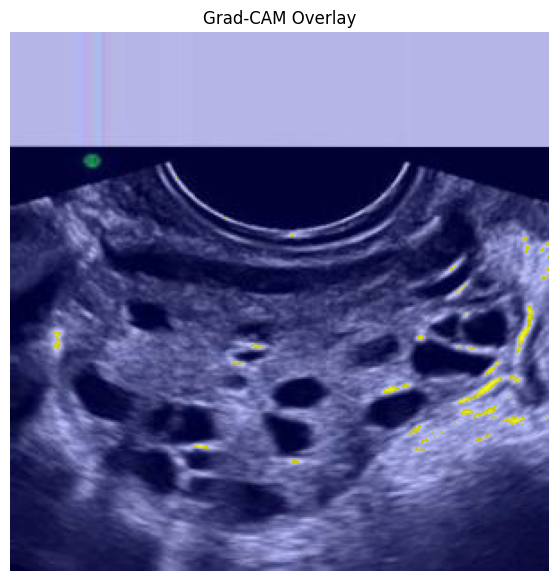

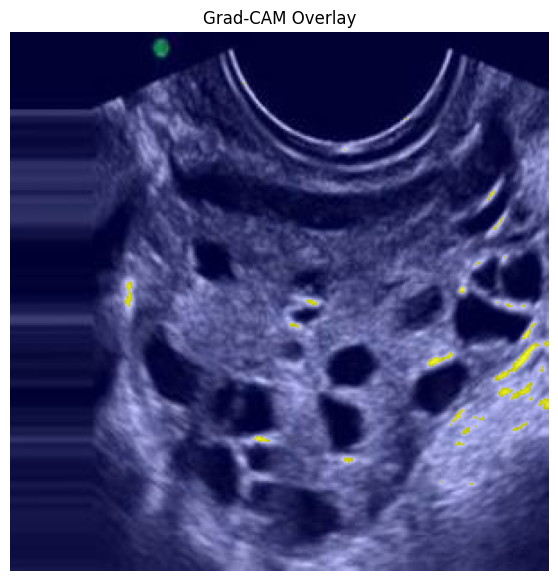

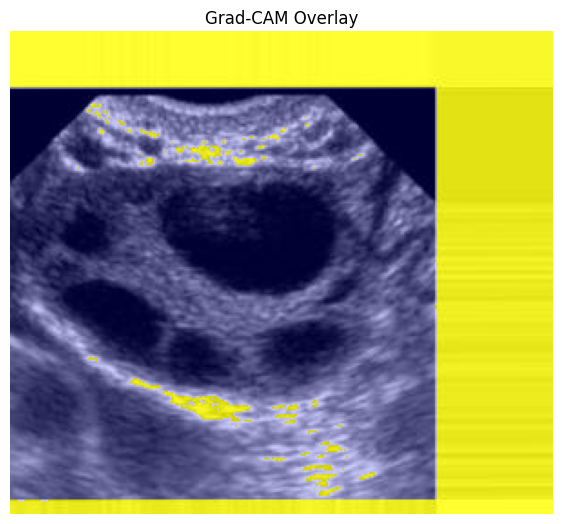

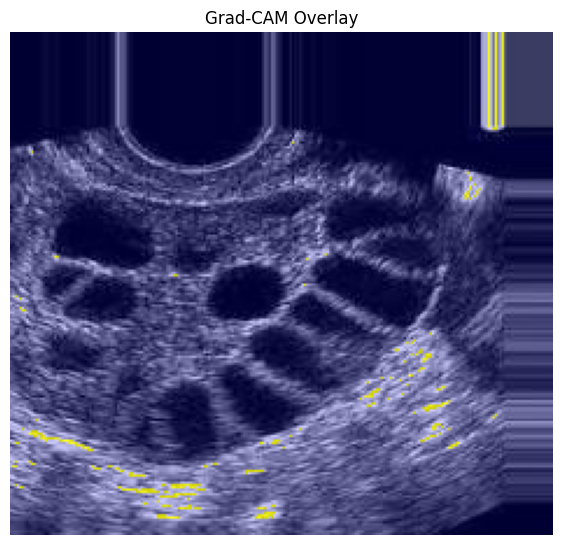

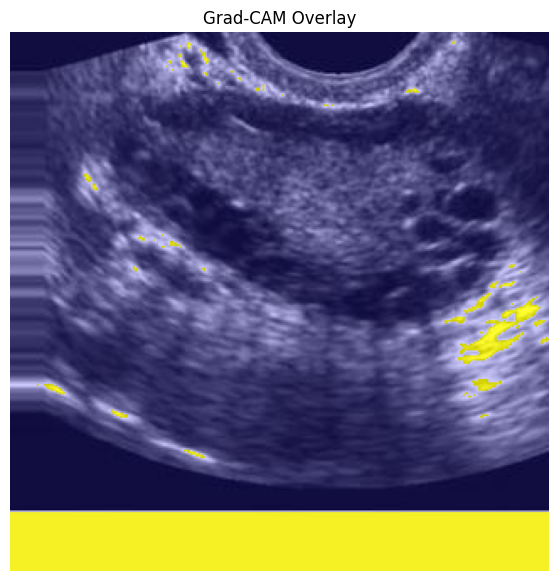

In [ ]:
pcos_img_dir = os.path.join(new_test_dir, "PCOS")
img_files = os.listdir(pcos_img_dir)[:5]  # Show for first 5 images

for img_file in img_files:
    img_path = os.path.join(pcos_img_dir, img_file)
    img_array = get_img_array(img_path, size=(224, 224))
    heatmap = make_gradcam_heatmap(img_array, model_mobilenet, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)
